## To - Do
- Double check solutions now are kinda as expected
- Boundary condition of outflow should be fixed (WIP)
- Naca profile should be implemented (Right now half a circle is possible)

# Navier-Stokes simulation in 2D
Currently only the simulation of a pressure driven lid is possible. This can be extended by adding more possibilities to the function 'set_BC'.

Init time 2.07 s
Iteration number: 1
Iteration number: 100


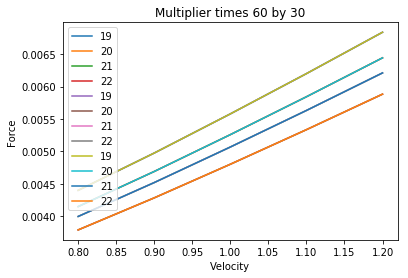

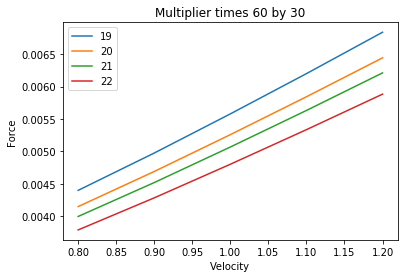

In [ ]:
#%matplotlib notebook
import time
import numpy as np

from types import SimpleNamespace

from functions import *
from constants import *
from simulation import *

start_time = time.time()

# Initial conditions 
const = SimpleNamespace()
const.Re = 1e1            # Reynolds number
const.dt = 1e-2           # time step
const.tf = 1e0            # final time
const.lx = 2              # width of box
const.ly = 1              # height of box
const.cholesky = True
const.velocity_arr = np.linspace(0.8, 1.2, 5)

# Grid multiplier options
multi_min = 4
multi_max = multi_min + 24

# Data Processing settings
const.nsteps = 400      # step interval for graphic output
const.rho_arrow = 10    # Density of arrows in quiver plot per unit length l
const.plot_P = True
const.plot_U = True
const.plot_Q = True

const.save_fig = False
const.fig_dir ='./movie_images/' 
const.fig_id = 'th' 

results = SimpleNamespace()
results.obj_F = np.zeros((multi_max+1-multi_min, len(const.velocity_arr)), dtype=float)

for j, multiplier in enumerate(np.arange(multi_min, multi_max + 1, 4)):
    const.nx = 60*multiplier  # number of x-gridpoints
    const.ny = 30*multiplier  # number of y-gridpoints
    
    const.fig_id = str(np.round(const.nx)) + '_' + str(np.round(const.ny)) + '_' + const.fig_id
    
    ## Set other constants (incl. grid) which are determined by initial conditions specified above
    const = constants(const)

    # IC's
    data = SimpleNamespace()
    data = initialisation(const, data)

    # BC's
    ## North, East, South, West
    bc = SimpleNamespace()
    boundary_type = 'horizontal_sea'

    ## Object 
    obj = SimpleNamespace(sort = 'hemicircle')
    obj = creat_obj(const, obj)

    # Operator matrices on P, U, V, Q respectively
    LP = SimpleNamespace()
    LP = laplacian(const, LP)
    LP = laplace_obj(const, LP, obj)
    if const.cholesky:
        LP = cholesky_decomposition(LP)

    init_time = time.time()
    print('Init time', np.round(init_time - start_time,2), 's')

    # Simulation
    for i, const.velocity in enumerate(const.velocity_arr):

        #BC's
        bc = set_BC(const, bc, boundary_type)

        # Boundary matrices
        bc = set_BM(const, bc)

        data = simulation(const, bc, obj, LP, data, boundary_type)

        results.obj_F[j, i] = data.obj_F

    end_time = time.time()
    print('Runtime', np.round(end_time - start_time,2), 's')

In [ ]:
fig = plt.figure()
for i, y_data in enumerate(results.obj_F):
    plt.plot(const.velocity_arr, y_data, label=str(multi_min + i))
plt.title('Multiplier times 60 by 30')
plt.ylabel('Force')
plt.xlabel('Velocity')
plt.legend()
plt.savefig('result.png', dpi=fig.dpi)

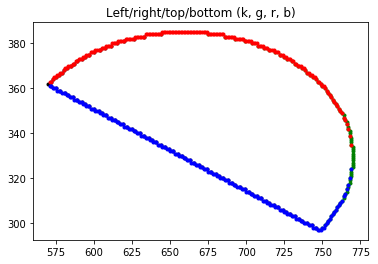

In [31]:
# Visual representation of the boundary of the object
plt.plot(obj.lbound[0], obj.lbound[1], 'k.')
plt.plot(obj.rbound[0], obj.rbound[1], 'g.')
plt.plot(obj.tbound[0], obj.tbound[1], 'r.')
plt.plot(obj.bbound[0], obj.bbound[1], 'b.')
plt.title('Left/right/top/bottom (k, g, r, b)')
plt.show()

# Energy check

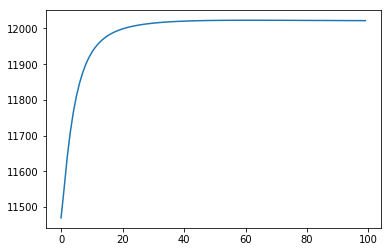

In [3]:
#%matplotlib notebook
plt.plot(data.kin_energy)
plt.show()

## Other Visualisation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x0 = 0
xL = const.nx

y0 = 0
yL = const.ny

Obj = obj.Pgrid

u_x = np.arange(x0+1, xL, 1)
u_y = np.arange(y0+0.5, yL+0.5, 1)
[X_u, Y_u] = np.meshgrid(u_x, u_y)

v_x = np.arange(x0+0.5, xL+0.5, 1)
v_y = np.arange(y0+1, yL, 1)
[X_v, Y_v] = np.meshgrid(v_x, v_y)

p_x = np.arange(x0+0.5, xL + 0.5, 1)
p_y = np.arange(y0+0.5, yL + 0.5, 1)
[X_p, Y_p] = np.meshgrid(p_x, p_y)

my_dpi = 96
plt.figure(figsize=(xL*40/my_dpi, yL*40/my_dpi), dpi=my_dpi)
plt.plot(np.reshape(X_u, (-1,)), np.reshape(Y_u, (-1,)), 'x', label='U')
plt.plot(np.reshape(X_v, (-1,)), np.reshape(Y_v, (-1,)), '+', label='V')
plt.plot(np.reshape(X_p, (-1,)), np.reshape(Y_p, (-1,)), 'o', label='P')

plt.plot(obj.coord_P[0] + 0.5, obj.coord_P[1] + 0.5, 'or')
plt.plot(obj.coord_U[0] + 1, obj.coord_U[1] + 0.5, 'xr')
plt.plot(obj.coord_V[0] + 0.5, obj.coord_V[1] + 1, '+r')
plt.plot(obj.coord_Q[0] + 1, obj.coord_Q[1] + 1, 'ob')

plt.legend()
plt.imshow(Obj.T, extent=[x0, xL, y0, yL])
plt.tight_layout()
plt.show()



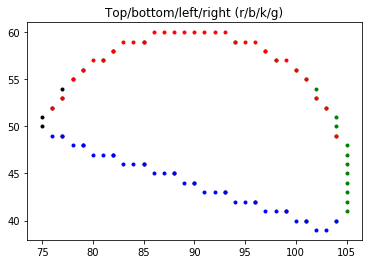

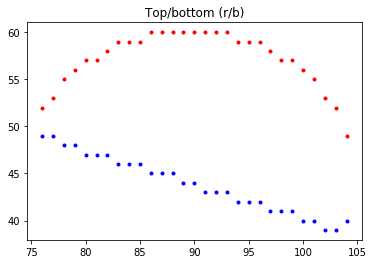

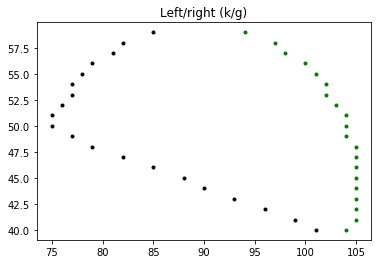

In [101]:
# Object identifier function (already implemented in function.py, stated here so vincent can take a look at it)
airfoil = obj.cgrid.T*1
roll_down = np.roll(airfoil, -1, 0)
roll_up = np.roll(airfoil, 1, 0)
roll_left = np.roll(airfoil, -1, 1)
roll_right = np.roll(airfoil, 1, 1)


bottom = (roll_down - airfoil).T
bottom = np.where(bottom == 1)

top = (roll_up - airfoil).T
top = np.where(top == 1)

left = (roll_left - airfoil).T
left = np.where(left == 1)

right = (roll_right - airfoil).T
right = np.where(right == 1)

plt.plot(left[0], left[1], 'k.')
plt.plot(right[0], right[1], 'g.')
plt.plot(bottom[0], bottom[1], 'b.')
plt.plot(top[0], top[1], 'r.')
plt.title('Top/bottom/left/right (r/b/k/g)')
plt.show()

plt.plot(bottom[0], bottom[1], 'b.')
plt.plot(top[0], top[1], 'r.')
plt.title('Top/bottom (r/b)')
plt.show()

plt.plot(left[0], left[1], 'k.')
plt.plot(right[0], right[1], 'g.')
plt.title('Left/right (k/g)')
plt.show()